In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Bài 1: Code from scratch hàm transposed convolution

In [3]:
def transpose_convolution(input_data, kernel, stride=1):
    input_height, input_width = input_data.shape
    kernel_height, kernel_width = kernel.shape

    output_height = input_height * stride
    output_width = input_width * stride

    output = np.zeros((output_height, output_width))

    for i in range(input_height):
        for j in range(input_width):
            for m in range(kernel_height):
                for n in range(kernel_width):
                    output[i * stride + m, j * stride + n] += input_data[i, j] * kernel[m, n]

    return output

input_data = np.array([[1, 2],
                      [3, 4]])
kernel = np.array([[1, 2],
                   [3, 4]])

stride = 2
output = transpose_convolution(input_data, kernel, stride)
print(output)


[[ 1.  2.  2.  4.]
 [ 3.  4.  6.  8.]
 [ 3.  6.  4.  8.]
 [ 9. 12. 12. 16.]]


## Bài 2: Cho dataset cifar-10
- Cho noise cho dataset được sample từ normal distribution (mean = 0, variance = 0.1)
- Dùng cấu trúc autoencoder để denoise lại bức ảnh về như ban đầu
- Visualize ảnh ban đầu, ảnh được thêm noise, và ảnh sau khi denoise.


In [4]:
# Chuẩn bị dữ liệu CIFAR-10
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

# Tạo một lớp Autoencoder đơn giản
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Chuẩn bị hàm nhiễu Gaussian
def add_gaussian_noise(image, mean=0, variance=0.1):
    noise = torch.randn(image.size()) * variance + mean
    noisy_image = image + noise
    return noisy_image

Files already downloaded and verified


In [11]:
# Huấn luyện Autoencoder
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

num_epochs = 20
for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        noisy_img = add_gaussian_noise(img).to(device)

        optimizer.zero_grad()
        outputs = model(noisy_img).to(device)
        loss = criterion(outputs, img.to(device))
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

sample_data, _ = next(iter(train_loader))
sample_data_noisy = add_gaussian_noise(sample_data)

model.eval()
output_data = model(sample_data_noisy.to(device))

Epoch [1/20], Loss: 0.0042
Epoch [2/20], Loss: 0.0030
Epoch [3/20], Loss: 0.0026
Epoch [4/20], Loss: 0.0027
Epoch [5/20], Loss: 0.0023
Epoch [6/20], Loss: 0.0029
Epoch [7/20], Loss: 0.0020
Epoch [8/20], Loss: 0.0020
Epoch [9/20], Loss: 0.0024
Epoch [10/20], Loss: 0.0026
Epoch [11/20], Loss: 0.0021
Epoch [12/20], Loss: 0.0019
Epoch [13/20], Loss: 0.0022
Epoch [14/20], Loss: 0.0021
Epoch [15/20], Loss: 0.0020
Epoch [16/20], Loss: 0.0024
Epoch [17/20], Loss: 0.0023
Epoch [18/20], Loss: 0.0022
Epoch [19/20], Loss: 0.0025
Epoch [20/20], Loss: 0.0021


In [12]:
noisy_img[0]

tensor([[[ 1.0563e-01,  2.4416e-01,  1.5362e-01,  ...,  1.7992e-01,
           1.5645e-01,  1.2557e-01],
         [ 2.2648e-01, -1.6995e-02, -2.6125e-02,  ...,  2.3307e-01,
           2.0680e-01,  1.8702e-01],
         [ 1.1850e-01,  1.5534e-01,  2.3076e-01,  ...,  1.7531e-01,
           2.1068e-01,  2.2264e-01],
         ...,
         [ 2.3909e-01,  2.1559e-03,  2.3857e-01,  ...,  2.2225e-01,
           3.8387e-01,  2.5333e-01],
         [ 2.5054e-01,  1.8783e-01,  1.8745e-01,  ...,  1.8109e-01,
           1.6228e-01,  2.2854e-01],
         [ 2.1313e-01,  1.1452e-01,  1.6523e-01,  ...,  2.2629e-01,
           1.9303e-01,  2.4965e-01]],

        [[ 1.1307e-01,  1.3510e-01,  3.5426e-02,  ...,  3.6142e-02,
           3.3456e-01,  1.3112e-01],
         [ 5.8885e-02,  8.3010e-02,  8.6702e-02,  ...,  2.4698e-01,
           2.2230e-01,  1.6927e-01],
         [ 1.6929e-01,  7.6055e-02,  1.9553e-01,  ...,  1.7436e-01,
           8.5045e-02,  6.0362e-02],
         ...,
         [ 1.5062e-02,  2

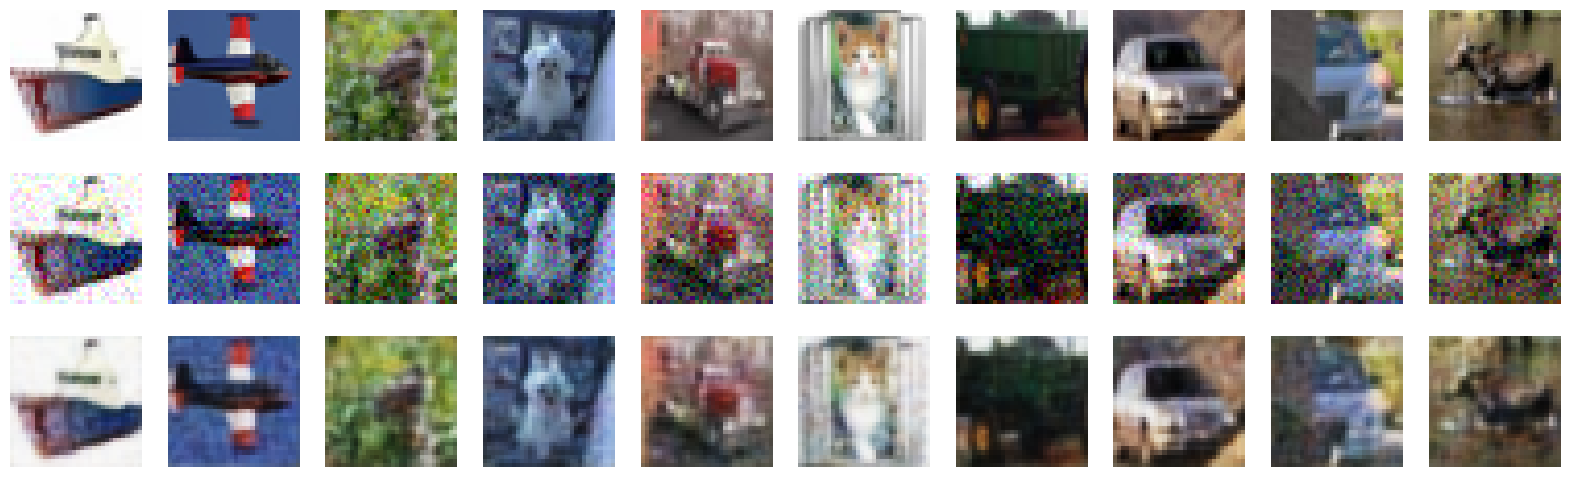

In [14]:
fig, axs = plt.subplots(3, 10, figsize=(20, 6))
for i in range(10):
    axs[0, i].imshow(sample_data[i].permute(1, 2, 0).numpy())
    axs[0, i].axis('off')
    axs[1, i].imshow(sample_data_noisy[i].permute(1, 2, 0).numpy())
    axs[1, i].axis('off')
    axs[2, i].imshow(output_data[i].cpu().detach().permute(1, 2, 0).numpy())
    axs[2, i].axis('off')

plt.show()

## Bài 3: : Cho dataset cifar-10
- Giảm chiều dữ liệu về dạng 2d của 1 ảnh bất kỳ bằng 2 phương pháp: PCA và convolution AE.
- Visualize và so sánh 2 phương pháp


In [15]:
# Thiết lập seed để đảm bảo sự tái lặp được tái sản sinh
# torch.manual_seed(42)
# np.random.seed(42)

# Chuẩn bị dữ liệu CIFAR-10
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

# Lấy một ví dụ ảnh từ dữ liệu CIFAR-10
sample_image, _ = train_dataset[0]

# Phương pháp 1: Giảm chiều bằng PCA
def apply_pca(data, n_components=2):
    data = data.view(-1, 3 * 32)  # Reshape thành mảng 2D
    pca = PCA(n_components=n_components)
    reduced_data = pca.fit_transform(data)
    return reduced_data

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            #nn.MaxPool2d(2, 2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 4, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 4, stride=2)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

def apply_autoencoder(data):
    model = Autoencoder()
    data = data.unsqueeze(0)  # Thêm chiều batch
    reduced_data = model(data)  # Reshape thành mảng 2D
    return reduced_data


Files already downloaded and verified


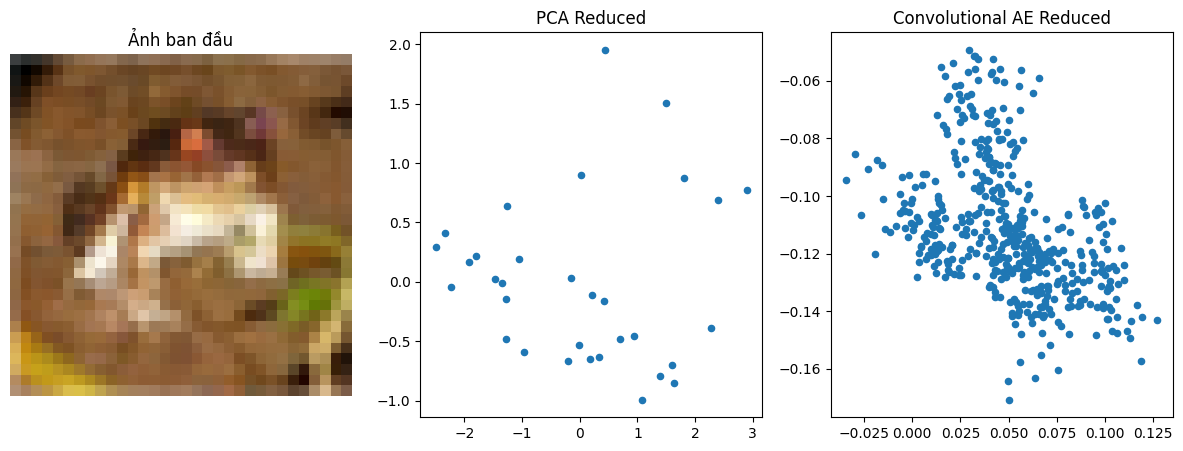

In [18]:
# Áp dụng PCA và Convolutional AE cho một ví dụ ảnh
pca_reduced = apply_pca(sample_image)
ae_reduced = apply_autoencoder(sample_image)

# Visualize và so sánh kết quả
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(sample_image.permute(1, 2, 0))
axs[0].set_title('Ảnh ban đầu')
axs[0].axis('off')

axs[1].scatter(pca_reduced[:, 0], pca_reduced[:, 1], s=20)
axs[1].set_title('PCA Reduced')

#axs[2].imshow(torch.tensor(ae_reduced).detach().numpy())
axs[2].scatter(ae_reduced[:, 0].detach().numpy(), ae_reduced[:, 1].detach().numpy(), s=20)
axs[2].set_title('Convolutional AE Reduced')

plt.show()


- Autoencoder học biểu diễn non-linear của dữ liệu thông qua một mô hình mã hóa và giải mã. Nó có khả năng học biểu diễn phức tạp hơn và có thể giữ lại nhiều thông tin hơn so với PCA.